In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import noise 
import pyvista as pv

%matplotlib inline

In [7]:
def normalize_vectors(vectors):
    """Normalizes a field of vectors."""
    # Calculate the norm , small epsilon to avoid division by zero
    norms = np.linalg.norm(vectors, axis=-1, keepdims=True)
    epsilon = 1e-8 , #small epsilon to avoid division by zero
    
    # Normalize the vectors by dividing by their norm
    normalized_vectors = np.divide(vectors, norms + epsilon, where=(norms != 0))
    return normalized_vectors

In [8]:

def generate_bending_fibers(shape=(50, 100, 100)): # default shape 50,100,100
    """
    Generates a block of fibers bending from the Y-axis to the X-axis.
    The bend occurs along the X-axis.
    """
    grid = np.zeros(shape + (3,))
    nx, ny, nz = shape # touple unpacking. assign the vaules in shape accordingly

    # Create coordinate arrays
    x = np.arange(nx)
    
    # The angle of bend is a function of the x-coordinate
    # It goes from 0 (pointing along Y) to pi/2 (pointing along X)
    angle = (np.pi / 2.0) * (x / (nx - 1))
    
    # Create vectors based on the angle
    vx = np.sin(angle)
    vy = np.cos(angle)
    
    # Assign the vectors to the grid, broadcasting across Y and Z
    grid[:, :, :, 0] = vx[:, np.newaxis, np.newaxis]
    grid[:, :, :, 1] = vy[:, np.newaxis, np.newaxis]
    grid[:, :, :, 2] = 0 

    return grid

def generate_fanning_fibers(shape=(50, 100, 100)):
    """
    Generates a block of fibers fanning out from a central line.
    The main direction is along the X-axis, and fanning occurs in the YZ-plane.
    """
    grid = np.zeros(shape + (3,))
    nx, ny, nz = shape

    # Define the center of the fan
    center_y, center_z = ny // 2, nz // 2

    # Create coordinate arrays
    y = np.arange(ny)
    z = np.arange(nz)

    # Calculate distance from the fan's center line
    dy = y - center_y
    dz = z - center_z

    # Calculate the angle of fanning in the YZ plane
    angle = np.arctan2(dz[np.newaxis, :], dy[:, np.newaxis])

    # Create vectors. The primary component is along X.
    # The spread of the fan is controlled by the magnitude of the Y and Z components.
    grid[:, :, :, 0] = 1.0 # Main direction along X
    grid[:, :, :, 1] = 0.4 * np.cos(angle)[np.newaxis, :, :] # Fanning in Y
    grid[:, :, :, 2] = 0.4 * np.sin(angle)[np.newaxis, :, :] # Fanning in Z

    return normalize_vectors(grid)

def generate_crossing_fibers(shape=(40, 40, 40)):
    """
    Generates a block with two crossing fiber populations using a checkerboard pattern.
    """
    grid = np.zeros(shape + (3,))
    nx, ny, nz = shape
    
    # Define the two fiber orientation vectors
    vec1 = np.array([1, 1, 0]) / np.sqrt(2)
    vec2 = np.array([1, -1, 0]) / np.sqrt(2)

    # Create a 3D checkerboard pattern to assign vectors
    i, j, k = np.indices(shape)
    checkerboard = (i + j + k) % 2 == 0
    
    # Assign vectors based on the checkerboard pattern
    grid[checkerboard] = vec1
    grid[~checkerboard] = vec2
    
    return grid

def generate_straight_fibers(shape, direction):
    """Generates a block of straight, parallel fibers."""
    grid = np.zeros(shape + (3,))
    
    # Ensure the direction vector is a unit vector
    unit_direction = np.array(direction) / np.linalg.norm(direction)
    
    grid[:] = unit_direction
    return grid

def generate_twisting_fibers(shape=(100, 100, 100)):
    """
    Generates a smoothly varying field of fibers that twist around the Z-axis.
    """
    grid = np.zeros(shape + (3,))
    nx, ny, nz = shape
    
    # Create 3D coordinate grids
    x, y, z = np.indices(shape)
    
    # Center the coordinates
    x_c = x - nx / 2
    y_c = y - ny / 2
    
    # Define the angle of twist based on the Z coordinate (more twist as you go up)
    # The 'twist_rate' controls how fast it twists
    twist_rate = np.pi / nz
    angle = z * twist_rate
    
    # Define the main vector field (e.g., pointing along Y)
    vx = -np.sin(angle)
    vy = np.cos(angle)
    vz = 0.2 # Give a slight upward component
    
    # Assign to the grid (requires stacking and transposing)
    vectors = np.stack([vx, vy, vz], axis=-1)
    
    return normalize_vectors(vectors)

def add_vector_noise(grid, noise_level=0.3):
    """
    Adds random noise to a vector field and re-normalizes.
    
    Args:
        grid (np.array): The input vector field.
        noise_level (float): The strength of the noise (0=none, 1=high).
    """
    # Create random noise vectors with the same shape as the grid
    noise = np.random.normal(0, 1, grid.shape)
    
    # Add the scaled noise to the original vectors
    noisy_grid = grid + noise * noise_level
    
    # Re-normalize the vectors to ensure they remain unit vectors
    return normalize_vectors(noisy_grid)

In [9]:
def add_simplex_noise(grid, strength=0.5, scale=20.0, octaves=4, seed=None):
    """
    Adds 3D Simplex noise to an existing vector field.

    Args:
        grid (np.array): The input (n, n, n, 3) vector field.
        strength (float): Controls the magnitude of the noise. 0 is no effect,
                          1.0 can significantly alter the original vectors.
        scale (float): The size of the noise features. Larger values create
                       smoother, larger waves of noise.
        octaves (int): The number of noise layers for added detail.
        seed (int): A seed to make the noise reproducible.
    """
    shape = grid.shape[:3]
    noise_field = np.zeros_like(grid)
    if seed is None:
        seed = np.random.randint(0, 100)

    # --- PERFORMANCE WARNING ---
    # This loop is slow for large grids because the 'noise' library is not
    # vectorized. For high performance, consider using a Numba-accelerated version.

    for i in range(shape[0]):
        for j in range(shape[1]):
            for k in range(shape[2]):
                # Normalize coordinates and apply scale
                x = i / shape[0] * scale
                y = j / shape[1] * scale
                z = k / shape[2] * scale

                # Generate three independent noise values for the noise vector
                nx = noise.snoise4(x, y, z, w=seed, octaves=octaves)
                ny = noise.snoise4(x, y, z, w=seed + 10, octaves=octaves)
                nz = noise.snoise4(x, y, z, w=seed + 20, octaves=octaves)

                noise_field[i, j, k] = [nx, ny, nz]

    # Add the scaled noise field to the original grid
    perturbed_grid = grid + noise_field * strength

    # Re-normalize the final vectors to ensure they are unit vectors
    return normalize_vectors(perturbed_grid)

In [10]:
print("--- Assembling a varied volume with random and noisy tiling ---")

master_shape = (100, 100, 100)

# --- Step 1: Initialize the master grid with a SMOOTH, RANDOM background ---
print("1. Creating a smooth, random background...")

# First, create vectors with components from a Gaussian distribution
background = np.random.normal(0, 1, master_shape + (3,))
# Then, normalize them to get uniformly random directions (unit vectors)
master_grid = normalize_vectors(background)

# --- Create an expanded list of fiber pattern generators ---
block_size = 5 # Use smaller blocks
sub_shape = (block_size, block_size, block_size)

pattern_generators = [
    # --- Original "Clean" Patterns ---
    lambda: generate_straight_fibers(sub_shape, direction=[1, 0, 0]),
    lambda: generate_straight_fibers(sub_shape, direction=[0, 1, 0]),
    lambda: generate_bending_fibers(sub_shape),
    lambda: generate_fanning_fibers(sub_shape),
    lambda: generate_crossing_fibers(sub_shape),
    
    # --- NEW: "Noisy" Versions of the Patterns ---
    lambda: add_vector_noise(generate_straight_fibers(sub_shape, direction=[1, 0, 0]), noise_level=0.4),
    lambda: add_vector_noise(generate_straight_fibers(sub_shape, direction=[0, 1, 0]), noise_level=0.4),
    lambda: add_vector_noise(generate_bending_fibers(sub_shape), noise_level=0.3),
    lambda: add_vector_noise(generate_fanning_fibers(sub_shape), noise_level=0.5)
]
print(f"Created a pool of {len(pattern_generators)} different pattern types (clean and noisy).")


# --- Loop through the master grid and place random blocks ---
print(f"Tiling the {master_shape} grid with {sub_shape} blocks...")
for x in range(0, master_shape[0], block_size):
    for y in range(0, master_shape[1], block_size):
        for z in range(0, master_shape[2], block_size):
            if random.random() < 0.7:
            # Choose a random pattern generator from the expanded list
                random_generator = random.choice(pattern_generators)
                
                # Generate the block
                new_block = random_generator()
                
                # Place it in the master grid
                master_grid[x:x+block_size, y:y+block_size, z:z+block_size] = new_block

master_grid = add_simplex_noise( master_grid,
    strength=0.7,   # A moderate amount of perturbation
    scale=30.0,     # Large features for a gentle, wavy look
    octaves=2       # Few octaves for smoothness
)

print("✅ Composite volume with random and noisy tiling assembled!")

--- Assembling a varied volume with random and noisy tiling ---
1. Creating a smooth, random background...
Created a pool of 9 different pattern types (clean and noisy).
Tiling the (100, 100, 100) grid with (5, 5, 5) blocks...
✅ Composite volume with random and noisy tiling assembled!


Found 1000000 non-zero vectors.
Converted vector directions to spherical coordinates (azimuth, elevation).
Generating 2D histogram of orientations...
✅ FOD visualization complete.


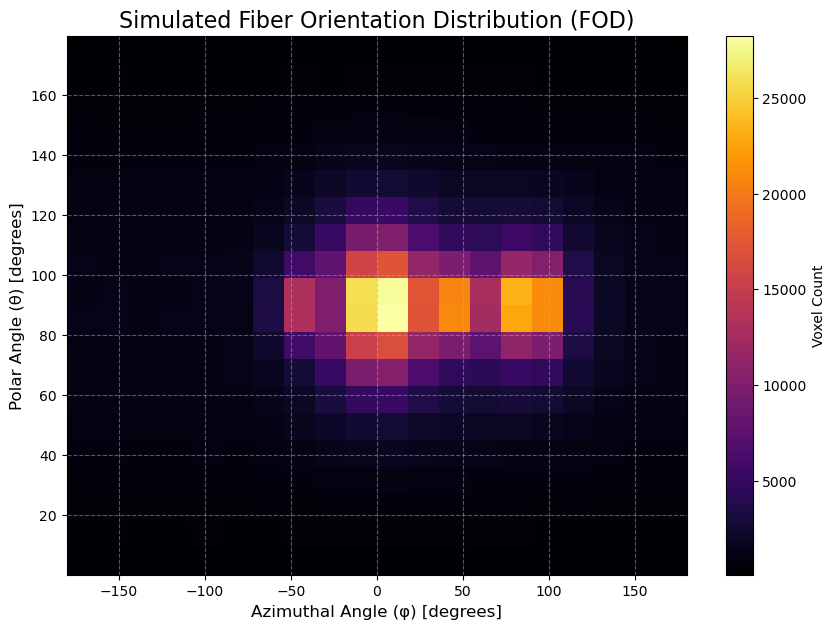

In [11]:
# --- Step 1: Reshape the data and filter out zero vectors ---
all_vectors = master_grid.reshape(-1, 3)
all_vectors = all_vectors[np.any(all_vectors != 0, axis=1)]
print(f"Found {all_vectors.shape[0]} non-zero vectors.")

# --- Step 2: Convert Cartesian vectors (x, y, z) to Spherical angles ---
x, y, z = all_vectors[:, 0], all_vectors[:, 1], all_vectors[:, 2]

# Azimuth (phi) is the angle in the xy-plane (from -pi to pi)
azimuth = np.arctan2(y, x)

# Elevation (theta) is the angle from the z-axis (from 0 to pi)
# Note: We need to clip the z value to avoid domain errors in arccos
elevation = np.arccos(np.clip(z, -1.0, 1.0))

print("Converted vector directions to spherical coordinates (azimuth, elevation).")

# --- Step 3: Create and visualize the 2D histogram ---
print("Generating 2D histogram of orientations...")

plt.figure(figsize=(10, 7))

# hist2d creates a 2D histogram (a heatmap) of the angles
# The bins define the resolution of our orientation histogram
plt.hist2d(np.degrees(azimuth), np.degrees(elevation), bins=20, cmap='inferno')

plt.colorbar(label='Voxel Count')
plt.title('Simulated Fiber Orientation Distribution (FOD)', fontsize=16)
plt.xlabel('Azimuthal Angle (φ) [degrees]', fontsize=12)
plt.ylabel('Polar Angle (θ) [degrees]', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)


print("✅ FOD visualization complete.")
plt.show()

In [12]:
# Unpack vector components for easier access
Vx = master_grid[..., 0]
Vy = master_grid[..., 1]
Vz = master_grid[..., 2]

# Create a PyVista StructuredGrid for advanced plotting
grid = pv.StructuredGrid(X, Y, Z)
# Add the vector data to the PyVista grid
grid["vectors"] = master_grid.reshape(-1, 3) # Reshape to (n*n*n, 3)

NameError: name 'X' is not defined